In [1]:
%matplotlib inline
import numpy as np
from sklearn.calibration import calibration_curve
from matplotlib import pyplot as plt
import pickle

import torch
from torch import nn
from torch.autograd import Variable
import torchvision.transforms as transforms

from models import tiramisu
from datasets import camvid
from datasets import joint_transforms
import utils.imgs
import utils.training as train_utils

# Training Models

Run the following commands:

`python train_model --gpu_id 0 --mode dropout --model_id 1`

`python train_model --gpu_id 0 --mode concrete --model_id 2`

`python train_model --gpu_id 0 --mode concrete --model_id 3`

`python train_model --gpu_id 0 --mode concrete --model_id 4`

# Loading Testing Data

In [2]:
CAMVID_PATH = 'SegNet-Tutorial/CamVid/'
image_size = 224
batch_size = 1
gpu_id = 0

classes_count = 12

dropout_model_id = 1
concrete_dropout_model_ids = [2, 3, 4]

normalize = transforms.Normalize(mean=camvid.mean, std=camvid.std)

test_joint_transformer = transforms.Compose([
    joint_transforms.JointCenterCrop(image_size),
])

test_dset = camvid.CamVid(
    CAMVID_PATH, 'test', joint_transform=test_joint_transformer,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize
    ]))
test_loader = torch.utils.data.DataLoader(
    test_dset, batch_size=batch_size, shuffle=False)

# Loading Models

In [3]:
# needed for compatibility, has no effect
dropout_data = {'mode': 'dropout', 'prob': 0.2}
concrete_dropout_data = {
    'mode': 'concrete_dropout',
    'init_min': 0.05,
    'init_max': 0.5,
    'weight_reg': 1e-8,
    'dropout_reg': 1e-2,
    'gpu_id': gpu_id
}

def load_model_and_training_data(model_id, gpu_id, dropout_data):

    model = tiramisu.FCDenseNet103(classes_count, dropout_data)

    model.load_state_dict(torch.load('weights/weights_{}.pth'.format(model_id)))
    model = model.cuda(gpu_id)

    with open('training_data/training_data_{}.pk'.format(model_id), 'rb') as dump_file:
        training_data = pickle.load(dump_file)

    return model, training_data

dropout_model, dropout_training_data = load_model_and_training_data(dropout_model_id, gpu_id, dropout_data)

cdropout_models = []
cdropout_training_datas = []

for model_id in concrete_dropout_model_ids:

    model, training_data = load_model_and_training_data(model_id, gpu_id, concrete_dropout_data)

    cdropout_models.append(model)
    cdropout_training_datas.append(training_data)

Initializing FCDenseNet103
Initializing FCDenseNet103


/misc/home/u0037/bml_project/fc_densenet/models/layers.py:53: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  nn.init.uniform(self.p_logit, a=init_min, b=init_max)


Initializing FCDenseNet103
Initializing FCDenseNet103


# Dropout Rate Convergence

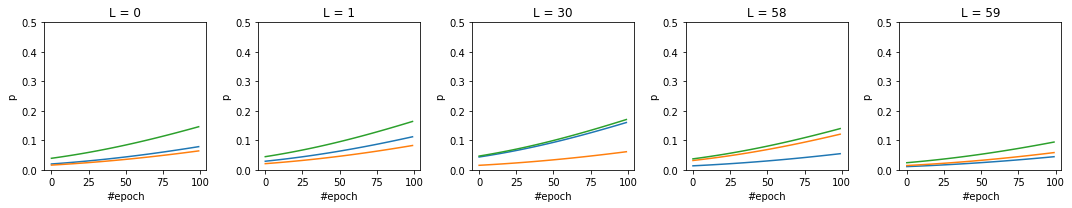

In [4]:
plt.figure(figsize=(15, 3))

layer_indices = [0, 1, 30, 58, 59]

for index, layer_index in enumerate(layer_indices):

    plt.subplot(1, 5, index + 1)

    for training_data in cdropout_training_datas:

        convergence = [x[3][layer_index] for x in training_data['epoch_data']]

        plt.plot(convergence)
        plt.title('L = {}'.format(layer_index))
        plt.xlabel('#epoch')
        plt.ylim([0, 0.5])
        plt.ylabel('p')

plt.tight_layout()
        
plt.show()

# Learning Curves

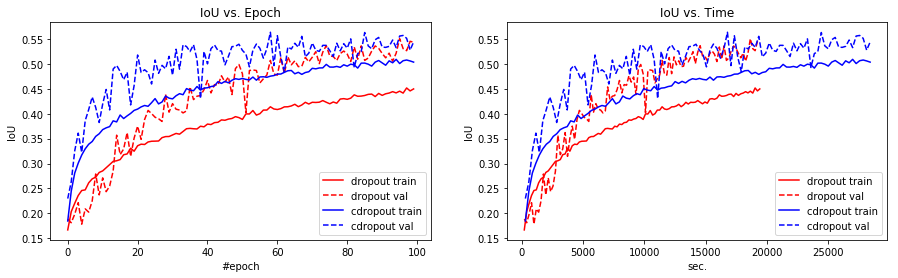

In [5]:
dropout_train_scores = [x[0] for x in dropout_training_data['epoch_data']]
dropout_val_scores = [x[1] for x in dropout_training_data['epoch_data']]
dropout_execution_times = [x[2] for x in dropout_training_data['epoch_data']]

cdropout_train_scores = [x[0] for x in cdropout_training_datas[0]['epoch_data']]
cdropout_val_scores = [x[1] for x in cdropout_training_datas[0]['epoch_data']]
cdropout_execution_times = [x[2] for x in cdropout_training_datas[0]['epoch_data']]

plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)

plt.plot(dropout_train_scores, 'r', label='dropout train')
plt.plot(dropout_val_scores, 'r--', label='dropout val')
plt.plot(cdropout_train_scores, 'b', label='cdropout train')
plt.plot(cdropout_val_scores, 'b--', label='cdropout val')
plt.legend()
plt.xlabel('#epoch')
plt.ylabel('IoU')
plt.title('IoU vs. Epoch')

plt.subplot(1, 2, 2)

plt.plot(dropout_execution_times, dropout_train_scores, 'r', label='dropout train')
plt.plot(dropout_execution_times, dropout_val_scores, 'r--', label='dropout val')
plt.plot(cdropout_execution_times, cdropout_train_scores, 'b', label='cdropout train')
plt.plot(cdropout_execution_times, cdropout_val_scores, 'b--', label='cdropout val')
plt.legend()
plt.xlabel('sec.')
plt.ylabel('IoU')
plt.title('IoU vs. Time')

plt.show()

# Performance on Test

In [6]:
criterion = nn.NLLLoss2d()

dropout_test_iou = train_utils.test(dropout_model, test_loader, criterion,
                                    gpu_id, 1, epoch=1)[1]
print('Dropout Test IOU - {}'.format(dropout_test_iou))

cdropout_test_iou = train_utils.test(cdropout_models[0], test_loader, criterion,
                                     gpu_id, 1, epoch=1)[1]
print('CDropout Test IOU - {}'.format(cdropout_test_iou))

cdropout_mc_test_iou = train_utils.test(cdropout_models[0], test_loader, criterion,
                                        gpu_id, 10, epoch=1)[1]
print('CDropout-MC Test IOU - {}'.format(cdropout_mc_test_iou))

/home/u0037/miniconda3/lib/python3.6/site-packages/torch/nn/modules/loss.py:206: UserWarning: NLLLoss2d has been deprecated. Please use NLLLoss instead as a drop-in replacement and see http://pytorch.org/docs/master/nn.html#torch.nn.NLLLoss for more details.
  warnings.warn("NLLLoss2d has been deprecated. "
/misc/home/u0037/bml_project/fc_densenet/utils/training.py:136: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data.cuda(gpu_id), volatile=True)
/misc/home/u0037/bml_project/fc_densenet/utils/training.py:146: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  test_loss += criterion(output, target).data[0]


Dropout Test IOU - 0.4015161423035115
CDropout Test IOU - 0.41410978684537925


/home/u0037/miniconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


CDropout-MC Test IOU - 0.4187012749326903


# Calibration

In [7]:
dropout_predictions = train_utils.predict(dropout_model, test_loader, gpu_id, 1)
cdropout_predictions = train_utils.predict(cdropout_models[0], test_loader, gpu_id, 1)
cdropout_mc_predictions = train_utils.predict(cdropout_models[0], test_loader, gpu_id, 10)

def get_ground_truth_and_probs(predictions):

    ground_truth = np.concatenate([x[0].numpy().ravel() for x in predictions])
    probs = np.concatenate([x[1].numpy().reshape(12, -1) for x in predictions], axis=1)

    return ground_truth, probs

dropout_gt, dropout_probs = get_ground_truth_and_probs(dropout_predictions)
cdropout_gt, cdropout_probs = get_ground_truth_and_probs(cdropout_predictions)
cdropout_mc_gt, cdropout_mc_probs = get_ground_truth_and_probs(cdropout_mc_predictions)

/misc/home/u0037/bml_project/fc_densenet/utils/training.py:173: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(input.cuda(gpu_id), volatile=True)


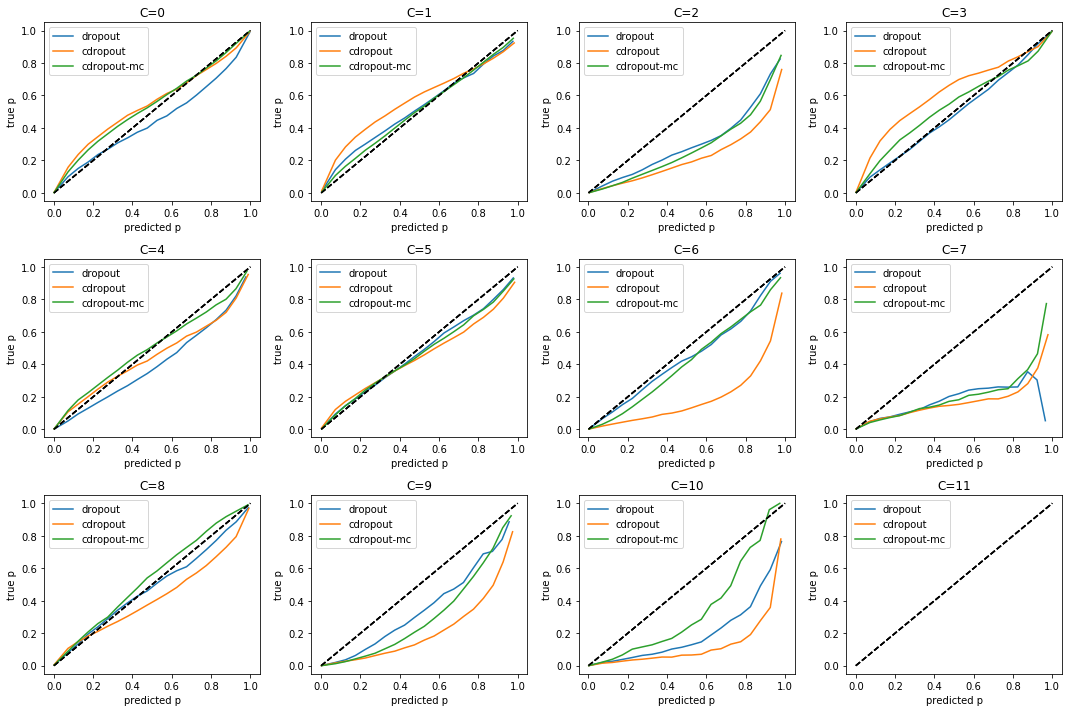

In [8]:
plt.figure(figsize=(15, 10))

for class_index in range(classes_count):

    plt.subplot(3, 4, class_index + 1)

    for ground_truth, probs, label in [(dropout_gt, dropout_probs, 'dropout'),
                                       (cdropout_gt, cdropout_probs, 'cdropout'),
                                       (cdropout_mc_gt, cdropout_mc_probs, 'cdropout-mc')]:

        true_probs, predicted_probs = calibration_curve(ground_truth == class_index,
                probs[class_index], n_bins=20)

        plt.plot(predicted_probs, true_probs, label=label)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('predicted p')
        plt.ylabel('true p')
        plt.title('C={}'.format(class_index))
        plt.legend()

plt.tight_layout()

plt.show()

# Example Output

/home/u0037/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/u0037/miniconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/u0037/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


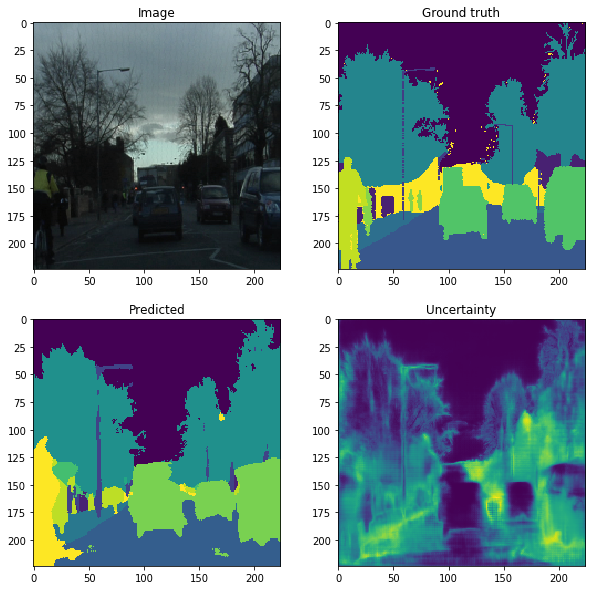

In [9]:
model = cdropout_models[0]

for image, ground_truth in test_loader:

    image = Variable(image, requires_grad=False).cuda(gpu_id)

    np_image = image.cpu().numpy()[0].transpose(1, 2, 0)

    np_image = np_image*np.array(camvid.std).reshape(1, 1, 3)
    np_image = np_image + np.array(camvid.mean).reshape(1, 1, 3)

    plt.figure(figsize=(10, 10))

    plt.subplot(2, 2, 1)
    plt.imshow(np_image)
    plt.title('Image')

    ground_truth = ground_truth.numpy()[0]

    plt.subplot(2, 2, 2)
    plt.imshow(ground_truth)
    plt.title('Ground truth')

    train_utils._set_dropout_state(model, False)

    output = nn.functional.softmax(model(image))
    
    output = output.detach().cpu().numpy()[0]

    output = output.argmax(axis=0)

    plt.subplot(2, 2, 3)
    plt.imshow(output)
    plt.title('Predicted')

    train_utils._set_dropout_state(model, True)

    outputs = []

    for sample_index in range(10):
        output = nn.functional.softmax(model(image))
        output = output.detach().cpu().numpy()[0]
        outputs.append(output)

    uncertainty = np.array(outputs).std(axis=0).sum(axis=0)
    
    plt.subplot(2, 2, 4)
    plt.imshow(uncertainty)
    plt.title('Uncertainty')

    plt.show()

    break